In [ ]:
!pip install fiftyone nuscenes-devkit

## Exploring nuScenes in FiftyOne
Due to the multi-sensor structure of nuScenes, the dataset in FiftyOne will be a [Grouped Dataset](https://docs.voxel51.com/user_guide/groups.html?_gl=1*1uqzezz*_gcl_au*MTI3OTEyMjEwMy4xNzI2MTQ5NDk3) with some [Dynamic Group Views](https://docs.voxel51.com/user_guide/using_views.html?_gl=1*1s195kz*_gcl_au*MTI3OTEyMjEwMy4xNzI2MTQ5NDk3#view-groups) thrown in there as well. At a high level, we will group together our samples by their associated scene in nuScenes. At regular intervals of each keyframe or approximately every 0.5 seconds (2Hz), we incorporate data from every sensor type, including their respective detections. This amalgamation of data results in distinct groups, each representing the sensor perspective at a given keyframe. We do have each sensor input for every frame, but since only keyframes are annotated, we choose to only load those in.  

## Ingesting nuScenes
To get started with nuScenes in FiftyOne, first we need to set up our environment for nuScenes. It will require downloading the dataset or a snippet of it as well as downloading the nuScenes python sdk. Full steps on installing can be found [here](https://www.nuscenes.org/nuscenes?tutorial=nuscenes).

Once your nuScenes is installed into your computer, we can kick things off. Let’s start by initializing both nuScenes as well as our FiftyOne dataset. We define our dataset as well as add a group to initialize the dataset to expect grouped data.

In [ ]:
from nuscenes import NuScenes
import fiftyone as fo

dataroot='/home/dan/Documents/models/drivestudio/data/nuscenes/raw/'
nusc = NuScenes(version='v1.0-mini', dataroot=dataroot, verbose=True)

dataset = fo.Dataset("nuscenes_cameras",overwrite=True)
dataset.add_group_field("group", default="CAM_FRONT")

## Loading Camera Data
Camera data is a bit more straightforward than the lidar data. There is no need to do any prep on the image or save it as a different format. We can go right ahead and grab the detections to add them. The only tricky part is these are no ordinary bounding boxes, they are 3D bounding boxes given in global coordinates!

Luckily for us, nuScenes provides some easy ways to convert their bounding boxes to our pixel space relative to what camera the image came from. For camera data, we load all of our boxes for our sample, check to see which ones are in the frame of our camera data, and then add the cuboids to the sample. In order to add a cuboid or a 3D bounding box, we use [polylines](https://docs.voxel51.com/user_guide/using_datasets.html?_gl=1*1vonm1t*_gcl_au*MTI3OTEyMjEwMy4xNzI2MTQ5NDk3#cuboids) and the [from_cuboid()](https://docs.voxel51.com/api/fiftyone.core.labels.html?_gl=1*z39nk3*_gcl_au*MTI3OTEyMjEwMy4xNzI2MTQ5NDk3#fiftyone.core.labels.Polyline.from_cuboid) method. Let’s take a look at how it is done:

In [ ]:
from nuscenes.utils.geometry_utils import box_in_image, view_points
import numpy as np
from nuscenes.utils.geometry_utils import  BoxVisibility
from nuscenes.scripts.export_poses import derive_latlon

def camera_sample(group, filepath, sensor, token, scene):
    sample = fo.Sample(filepath=filepath, group=group.element(sensor))
    data_path, boxes, camera_intrinsic = nusc.get_sample_data(token, box_vis_level=BoxVisibility.NONE,)
    image = Image.open(data_path)
    width, height = image.size
    shape = (height,width)
    polylines = []
    log = nusc.get('log', scene["log_token"])
    location = log["location"]
    ego = nusc.get('ego_pose', data["ego_pose_token"])
    ego_list = [ego]

    latlon = derive_latlon(location,ego_list)
    lat = latlon[0]["latitude"]
    lon = latlon[0]["longitude"]
    sample["location"] = fo.GeoLocation(
        point = [lon,lat]
    )
    for box in boxes:
        if box_in_image(box,camera_intrinsic,shape,vis_level=BoxVisibility.ALL):
            c = np.array(nusc.colormap[box.name]) / 255.0
            #print(box.name)
            corners = view_points(box.corners(), camera_intrinsic, normalize=True)[:2, :]
            front = [(corners[0][0]/width,corners[1][0]/height),
                    (corners[0][1]/width,corners[1][1]/height),
                    (corners[0][2]/width,corners[1][2]/height),
                    (corners[0][3]/width,corners[1][3]/height),]
            back =  [(corners[0][4]/width,corners[1][4]/height),
                    (corners[0][5]/width,corners[1][5]/height),
                    (corners[0][6]/width,corners[1][6]/height),
                    (corners[0][7]/width,corners[1][7]/height),]
            #print(corners.shape)
            polylines.append(fo.Polyline.from_cuboid(front + back, label=box.name))
    sample["cuboids"] = fo.Polylines(polylines=polylines)
    return sample

## Adding Samples to the Dataset
Next we need to add our camera samples to make our first dataset! Lets loop through all the scenes and add each camera angle, forming groups of 6 samples each.

In [ ]:
from PIL import Image
from nuscenes.utils.geometry_utils import view_points, BoxVisibility, box_in_image
import numpy as np
import os

# Define our sensor groups
groups = ["CAM_FRONT", "CAM_FRONT_RIGHT", "CAM_BACK_RIGHT", "CAM_BACK",
           "CAM_BACK_LEFT", "CAM_FRONT_LEFT",]

samples = []

# Iterate over each scene
for scene in nusc.scene:
    my_scene = scene
    token = my_scene['first_sample_token']
    my_sample = nusc.get('sample', token)
    last_sample_token = my_scene['last_sample_token']
    
    # Iterate over each sample in the scene
    while not my_sample["next"] == "":
        scene_token = my_sample["scene_token"]
        group = fo.Group()
        # Iterate over each sensor in the sample
        for sensor in groups:
            data = nusc.get('sample_data', my_sample['data'][sensor])
            filepath = dataroot + data["filename"]

            # Check if the sensor is a camera
            if data["sensor_modality"] == "camera":
                sample = camera_sample(group, filepath, sensor, my_sample['data'][sensor],scene)

            # Add metadata to the sample
            sample["token"] = data["token"]
            sample["ego_pose_token"] = data["ego_pose_token"]
            sample["calibrated_sensor_token"] = data["calibrated_sensor_token"]
            sample["timestamp"] = data["timestamp"]
            sample["is_key_frame"] = data["is_key_frame"]
            sample["prev"] = data["prev"]
            sample["next"] = data["next"]
            sample["scene_token"] = scene_token

            
            samples.append(sample)

        token = my_sample["next"]

        my_sample = nusc.get('sample', token)

# Add the samples to the dataset, group by scene_token, and launch the app     
dataset.add_samples(samples)
view = dataset.group_by("scene_token", order_by="timestamp")
session = fo.launch_app(view)

## Loading in Point Cloud Data

In [ ]:
# New dataset for all sensors including LIDAR and RADAR
all_sensor_dataset = fo.Dataset("nuscenes_sensors",overwrite=True)
all_sensor_dataset.add_group_field("group", default="CAM_FRONT")

Loading a LIDAR sample from nuScenes is composed of two steps, generating the pointcloud and adding the detections. We must convert the binary point clouds to standard in order to ingest them. nuScenes also offers a LIDAR segmentation optional package that allows us to color each point cloud point a color corresponding to its class that we will be utilizing. We start with our lidar token, load in the color map and point cloud that corresponds to the token, and save them back to file with the new coloring and standard `pcd` point cloud file formatting.

In [ ]:
from nuscenes.utils.data_io import load_bin_file
from nuscenes.utils.color_map import get_colormap
from nuscenes.lidarseg.lidarseg_utils import paint_points_label
from nuscenes.utils.data_classes import LidarPointCloud
import open3d as o3d
import os

def load_lidar(lidar_token):

    #Grab and Generate Colormaps
    gt_from = "lidarseg"
    lidarseg_filename = dataroot + nusc.get(gt_from, lidar_token)['filename']
    colormap = get_colormap()
    name2index = nusc.lidarseg_name2idx_mapping

    coloring = paint_points_label(lidarseg_filename,None,name2index, colormap=colormap)
    filepath = dataroot + nusc.get("sample_data", lidar_token)['filename']
    root, extension = os.path.splitext(filepath)

    #Load Point Cloud
    cloud = LidarPointCloud.from_file(filepath)
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(cloud.points[:3,:].T)
    colors = coloring[:,:3]
    colors.max()
    pcd.colors = o3d.utility.Vector3dVector(colors)

    #Save back Point Cloud
    o3d.io.write_point_cloud(root, pcd)

    return root

With our point cloud file now properly prepared for ingestion, we can move along to adding detections. To do so, we grab all the detections from the keyframe. We use nuScenes SDK’s builtin box methods to retrieve the location, rotation, and dimensions of the box. To match FiftyOne’s [3D detection input](https://docs.voxel51.com/user_guide/using_datasets.html?_gl=1*mn36m*_gcl_au*MTI3OTEyMjEwMy4xNzI2MTQ5NDk3#d-detections), we take `box.orientation.yaw_pitch_roll` for rotation, `box.wlh` for width, length, and height, and  `box.center` for its location. Note too that `fo.Sample(filepath=filepath, group=group.element(sensor))` will automatically detect the pcd file and ingest the sample as a point cloud as well! After the method is run and detections are added, we have our LIDAR sample with detections!

In [ ]:
from nuscenes.utils.geometry_utils import  BoxVisibility
from nuscenes.scripts.export_poses import derive_latlon

def lidar_sample(group, filepath, sensor, lidar_token, scene):
    # Get the lidar data
    data_path, boxes, camera_intrinsic = nusc.get_sample_data(lidar_token, box_vis_level=BoxVisibility.NONE,)
    data = nusc.get('sample_data', lidar_token)
    log = nusc.get('log', scene["log_token"])
    location = log["location"]
    ego = nusc.get('ego_pose', data["ego_pose_token"])
    ego_list = [ego]
    latlon = derive_latlon(location,ego_list)
    lat = latlon[0]["latitude"]
    lon = latlon[0]["longitude"]

    # Create a sample
    sample = fo.Sample(filepath=filepath, group=group.element(sensor))

    # Add the coords to the sample
    sample["location"] = fo.GeoLocation(
        point = [lon,lat]
    )
    
    # Add detections to the pcd
    detections = []
    for box in boxes:
                    
        x, y, z = box.orientation.yaw_pitch_roll
        w, l, h = box.wlh.tolist()

        detection = fo.Detection(
                label=box.name,
                location=box.center.tolist(),
                rotation=[z, y, x],
                dimensions=[l,w,h]
                )
        detections.append(detection)
    sample["ground_truth"] = fo.Detections(detections=detections)
    return sample

RADAR is an interesting case. Since we have already stored our 3d detections in the LIDAR sample and RADAR is laid on top of the LIDAR in the 3D visualizer, we don’t need to copy our detections for each point cloud. The simplifies loading RADAR to just:

In [ ]:
from nuscenes.utils.data_classes import RadarPointCloud
from pyquaternion import Quaternion
import numpy as np

def load_radar(filepath, data ):

    root, extension = os.path.splitext(filepath)
    
    #Load Point Cloud
    pc = RadarPointCloud.from_file(filepath)

    cs_record = nusc.get('calibrated_sensor', data['calibrated_sensor_token'])
    pc.rotate(Quaternion(cs_record['rotation']).rotation_matrix)
    pc.translate(np.array(cs_record['translation']))

    pcd = o3d.geometry.PointCloud()
    print(pc.points.shape)
    pcd.points = o3d.utility.Vector3dVector(pc.points[:3,:].T)

    #Save back Point Cloud
    o3d.io.write_point_cloud(root+"_NEW.pcd", pcd)
    
    return root+"_NEW.pcd"


Let's run it back again except this time we are taking cameras, LIDAR, and RADAR samples!

In [ ]:
groups = ["CAM_FRONT", "CAM_FRONT_RIGHT", "CAM_BACK_RIGHT", "CAM_BACK",
           "CAM_BACK_LEFT", "CAM_FRONT_LEFT","LIDAR_TOP", "RADAR_FRONT",
           "RADAR_FRONT_LEFT", "RADAR_FRONT_RIGHT", "RADAR_BACK_LEFT", "RADAR_BACK_RIGHT"]

samples = []
# Iterate over each scene
for scene in nusc.scene:
    my_scene = scene
    token = my_scene['first_sample_token']
    my_sample = nusc.get('sample', token)
    last_sample_token = my_scene['last_sample_token']
    
    # Iterate over each sample in the scene
    while not my_sample["next"] == "":
        scene_token = my_sample["scene_token"]
        lidar_token = my_sample["data"]["LIDAR_TOP"]
        group = fo.Group()
        # Iterate over each sensor in the sample
        for sensor in groups:
            data = nusc.get('sample_data', my_sample['data'][sensor])
            filepath = dataroot + data["filename"]

            # Check if the sensor is lidar
            if data["sensor_modality"] == "lidar":
                filepath = load_lidar(lidar_token)
                sample = lidar_sample(group,filepath, sensor, lidar_token, scene)

            # Check if the sensor is camera
            elif data["sensor_modality"] == "camera":
                sample = camera_sample(group, filepath, sensor, my_sample['data'][sensor],scene)

            # Else its radar
            else:
                radar_filepath = load_radar(filepath,data)
                sample = fo.Sample(filepath=radar_filepath, group=group.element(sensor))

            
            # Add metadata to the sample
            sample["token"] = data["token"]
            sample["ego_pose_token"] = data["ego_pose_token"]
            sample["calibrated_sensor_token"] = data["calibrated_sensor_token"]
            sample["timestamp"] = data["timestamp"]
            sample["is_key_frame"] = data["is_key_frame"]
            sample["prev"] = data["prev"]
            sample["next"] = data["next"]
            sample["scene_token"] = scene_token

            
            samples.append(sample)

        token = my_sample["next"]

        my_sample = nusc.get('sample', token)

# Add the samples to the dataset, group by scene_token, and launch the app
all_sensor_dataset.add_samples(samples)
view = all_sensor_dataset.group_by("scene_token", order_by="timestamp")
session.dataset = all_sensor_dataset

# Advanced Techniques
Let's begin looking at some advance methods we can do with our self driving dataset by flattening our group dataset. By default, a grouped dataset returns only one active slice when you grab a sample. If you want to look at all cameras at once, we can call `select_group_slices` and pass a media type or a list of group names to get the flattened samples back.

In [5]:
# Get all the image samples from the dataset
flattened_dataset = all_sensor_dataset.select_group_slices(media_type="image")

## Leveraging Embeddings
One of the strongest ways we can interact with our self driving car dataset is by using embeddings. By utilizing the [FiftyOne Brain](https://docs.voxel51.com/brain.html#), we can can compute embedddings on our dataset and do some awesome things. Let's check them out! 

### [Compute Visualization](https://docs.voxel51.com/brain.html#visualizing-embeddings)

In [ ]:
import fiftyone.brain as fob

results = fob.compute_visualization(
    flattened_dataset,  
    brain_key="embedding_viz",
    model="clip-vit-base32-torch"
)

### [Compute Similarity](https://docs.voxel51.com/brain.html#similarity)

In [ ]:
fob.compute_similarity(
    flattened_dataset,
    model="clip-vit-base32-torch",
    brain_key="img_sim",
)

In [ ]:
session.view = flattened_dataset

You can also use the FiftyOne Brain to find :
- [Most unique samples](https://docs.voxel51.com/brain.html#image-uniqueness)
- [Likely label mistakes](https://docs.voxel51.com/brain.html#label-mistakes)
- [Your hardest samples](https://docs.voxel51.com/brain.html#sample-hardness)
- [Most Representative Samples](https://docs.voxel51.com/brain.html#image-representativeness)

In [1]:
import fiftyone as fo

all_sensor_dataset = fo.load_dataset("nuscenes_sensors")

In [6]:
session.view = all_sensor_dataset.take(6)


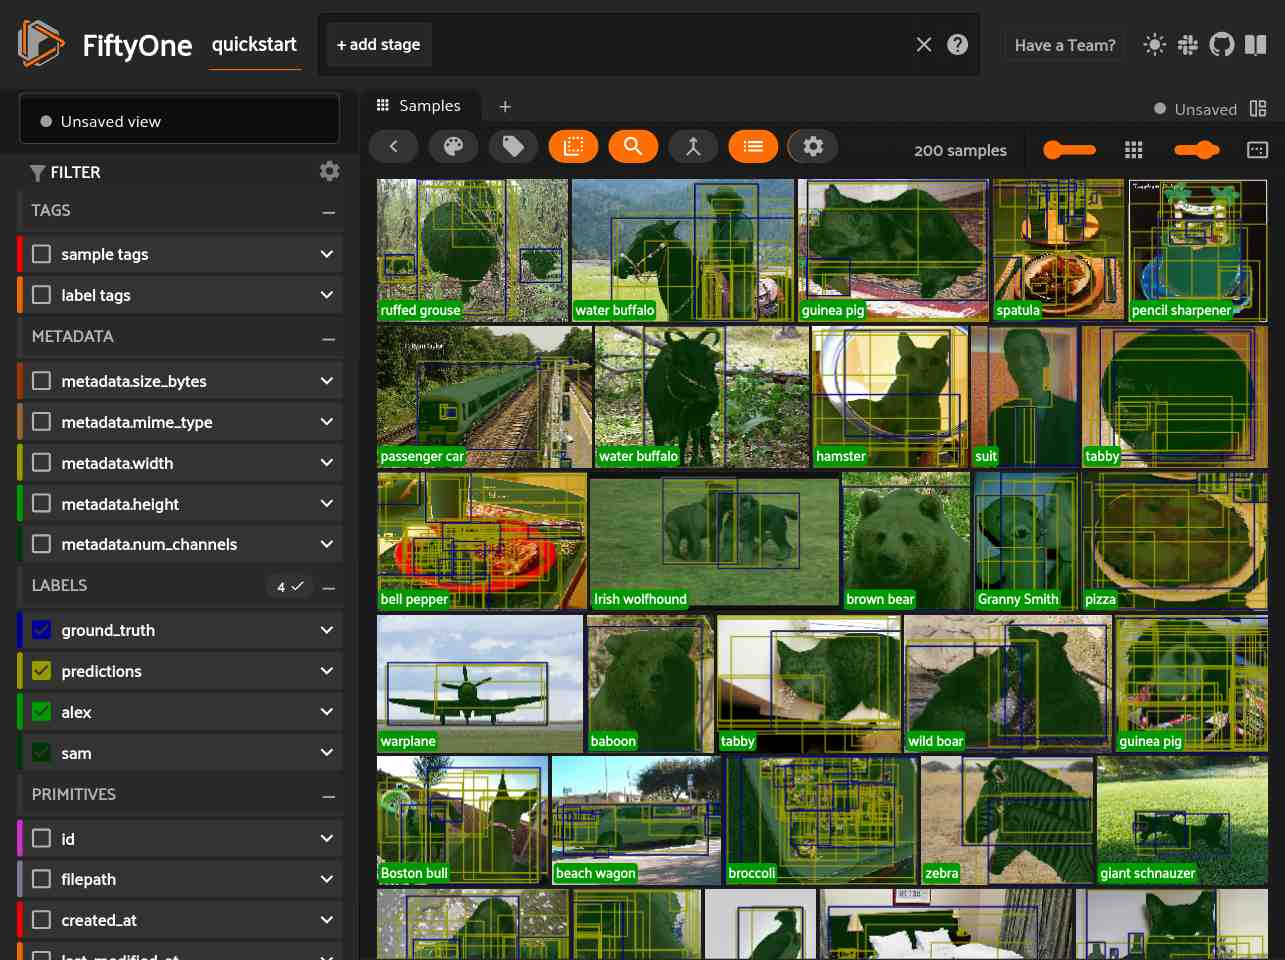


Welcome to

███████╗██╗███████╗████████╗██╗   ██╗ ██████╗ ███╗   ██╗███████╗
██╔════╝██║██╔════╝╚══██╔══╝╚██╗ ██╔╝██╔═══██╗████╗  ██║██╔════╝
█████╗  ██║█████╗     ██║    ╚████╔╝ ██║   ██║██╔██╗ ██║█████╗
██╔══╝  ██║██╔══╝     ██║     ╚██╔╝  ██║   ██║██║╚██╗██║██╔══╝
██║     ██║██║        ██║      ██║   ╚██████╔╝██║ ╚████║███████╗
╚═╝     ╚═╝╚═╝        ╚═╝      ╚═╝    ╚═════╝ ╚═╝  ╚═══╝╚══════╝ v1.2.0

If you're finding FiftyOne helpful, here's how you can get involved:

|
|  ⭐⭐⭐ Give the project a star on GitHub ⭐⭐⭐
|  https://github.com/voxel51/fiftyone
|
|  🚀🚀🚀 Join the FiftyOne Slack community 🚀🚀🚀
|  https://slack.voxel51.com
|



In [2]:
session = fo.launch_app(all_sensor_dataset)

In [6]:
import fiftyone.zoo as foz

model = foz.load_zoo_model("segment-anything-2-hiera-tiny-image-torch")
# Prompt with boxes
flattened_dataset.apply_model(
    model,
    label_field="sam2",
)

/home/dan/anaconda3/envs/dev/lib/python3.10/site-packages/sam2/modeling/sam/transformer.py:270: UserWarning: Memory efficient kernel not used because: (Triggered internally at ../aten/src/ATen/native/transformers/cuda/sdp_utils.cpp:773.)
  out = F.scaled_dot_product_attention(q, k, v, dropout_p=dropout_p)
/home/dan/anaconda3/envs/dev/lib/python3.10/site-packages/sam2/modeling/sam/transformer.py:270: UserWarning: Memory Efficient attention has been runtime disabled. (Triggered internally at ../aten/src/ATen/native/transformers/sdp_utils_cpp.h:558.)
  out = F.scaled_dot_product_attention(q, k, v, dropout_p=dropout_p)
/home/dan/anaconda3/envs/dev/lib/python3.10/site-packages/sam2/modeling/sam/transformer.py:270: UserWarning: Flash attention kernel not used because: (Triggered internally at ../aten/src/ATen/native/transformers/cuda/sdp_utils.cpp:775.)
  out = F.scaled_dot_product_attention(q, k, v, dropout_p=dropout_p)
/home/dan/anaconda3/envs/dev/lib/python3.10/site-packages/sam2/modeling

   4% |/--------------|   94/2364 [3.0m elapsed, 1.2h remaining, 0.5 samples/s]  

In [ ]:
model = foz.load_zoo_model("depth-estimation-transformer-torch")

flattened_dataset.apply_model(model, label_field="depth")

In [ ]:
# Processed cameras:
#   idx    camera           original size
#    0    CAM_FRONT         (900, 1600)
#    1    CAM_FRONT_LEFT    (900, 1600)
#    2    CAM_FRONT_RIGHT   (900, 1600)
#    3    CAM_BACK_LEFT     (900, 1600)
#    4    CAM_BACK_RIGHT    (900, 1600)
#    5    CAM_BACK          (900, 1600)

In [ ]:
idx_map = {"CAM_FRONT": 0, "CAM_FRONT_LEFT": 1, "CAM_FRONT_RIGHT": 2, "CAM_BACK_LEFT": 3, "CAM_BACK_RIGHT": 4, "CAM_BACK": 5}

In [ ]:
from fiftyone import ViewField as F
dataset2 = dataset.match(F("scene_token")=="cc8c0bf57f984915a77078b10eb33198").clone()

In [ ]:
dataset2.name="nuscenes_scene_0"
dataset.persistent = True

In [ ]:
i = 0
hz_adj = 5
cam_groups = ["CAM_FRONT", "CAM_FRONT_RIGHT", "CAM_BACK_RIGHT", "CAM_BACK",
           "CAM_BACK_LEFT", "CAM_FRONT_LEFT",]
for group in dataset2.iter_groups():
    for sensor in group:
        if sensor in cam_groups:
            frame_num = i * hz_adj
            cam_num = idx_map[sensor]
            filename = f"{str(frame_num).zfill(3)}_{cam_num}.png"
            sample = group[sensor]
            sample["sky_mask"] = fo.Segmentation(
                mask_path="/home/dan/Documents/models/drivestudio/data/nuscenes/processed_10Hz/mini/000/sky_masks/"+filename
                )
            sample["dynamic_mask_all"] = fo.Segmentation(
                mask_path="/home/dan/Documents/models/drivestudio/data/nuscenes/processed_10Hz/mini/000/dynamic_masks/all/"+filename
                )
            sample["fine_dynamic_mask_all"] = fo.Segmentation(
                mask_path="/home/dan/Documents/models/drivestudio/data/nuscenes/processed_10Hz/mini/000/fine_dynamic_masks/all/"+filename
                )
            sample["dynamic_mask_human"] = fo.Segmentation(
                mask_path="/home/dan/Documents/models/drivestudio/data/nuscenes/processed_10Hz/mini/000/dynamic_masks/human/"+filename
                )
            sample["fine_dynamic_mask_human"] = fo.Segmentation(
                mask_path="/home/dan/Documents/models/drivestudio/data/nuscenes/processed_10Hz/mini/000/fine_dynamic_masks/human/"+filename
                )
            sample["dynamic_mask_vehicle"] = fo.Segmentation(
                mask_path="/home/dan/Documents/models/drivestudio/data/nuscenes/processed_10Hz/mini/000/dynamic_masks/vehicle/"+filename
                )
            sample["fine_dynamic_mask_vehicle"] = fo.Segmentation(
                mask_path="/home/dan/Documents/models/drivestudio/data/nuscenes/processed_10Hz/mini/000/fine_dynamic_masks/vehicle/"+filename
                )
            
            sample.save()
    i += 1

In [ ]:
session.dataset = dataset2

In [1]:
import fiftyone as fo

dataset2 = fo.load_dataset("nuscenes_scene_0")

In [2]:
session = fo.launch_app(dataset2)                   

In [ ]:
cam_groups = ["CAM_FRONT", "CAM_FRONT_RIGHT", "CAM_BACK_RIGHT", "CAM_BACK",
           "CAM_BACK_LEFT", "CAM_FRONT_LEFT",]

In [ ]:
import fiftyone.zoo as foz

model = foz.load_zoo_model("segment-anything-2-hiera-tiny-image-torch")
# Prompt with boxes
dataset2.select_group_slices(cam_groups).apply_model(
    model,
    label_field="sam2",
)

In [ ]:
import fiftyone.zoo as foz

model = foz.load_zoo_model("depth-estimation-transformer-torch")

dataset2.select_group_slices(cam_groups).apply_model(model, label_field="depth")

In [ ]:
session = fo.launch_app(dataset2)

In [ ]:
import fiftyone as fo

dataset3 = fo.Dataset("nuscenes_splats",overwrite=True)
dataset3.add_group_field("group", default="Background_RGBS")
group = fo.Group()
samples = []

sample = fo.Sample(
    filepath="/home/dan/Documents/models/drivestudio/outputs/ns0/ns0/videos/full_set_30000_Background_rgbs.mp4",
     group=group.element("Background_RGBS")
     )
samples.append(sample)

sample = fo.Sample(
    filepath="/home/dan/Documents/models/drivestudio/outputs/ns0/ns0/videos/full_set_30000_DeformableNodes_rgbs.mp4",
     group=group.element("DeformableNodes_RGBS")
     )
samples.append(sample)

sample = fo.Sample(
    filepath="/home/dan/Documents/models/drivestudio/outputs/ns0/ns0/videos/full_set_30000_Dynamic_rgbs.mp4",
     group=group.element("Dynamic_RGBS")
     )
samples.append(sample)

sample = fo.Sample(
    filepath="/home/dan/Documents/models/drivestudio/outputs/ns0/ns0/videos/full_set_30000_gt_rgbs.mp4",
     group=group.element("GT_RGBS")
     )
samples.append(sample)

sample = fo.Sample(
    filepath="/home/dan/Documents/models/drivestudio/outputs/ns0/ns0/videos/full_set_30000_rgbs.mp4",
     group=group.element("RGBS")
     )
samples.append(sample)

sample = fo.Sample(
    filepath="/home/dan/Documents/models/drivestudio/outputs/ns0/ns0/videos/full_set_30000_RigidNodes_rgbs.mp4",
     group=group.element("RigidNodes_RGBS")
     )
samples.append(sample)

sample = fo.Sample(
    filepath="/home/dan/Documents/models/drivestudio/outputs/ns0/ns0/videos/full_set_30000_SMPLNodes_rgbs.mp4",
     group=group.element("SMPLNodes_RGBS")
     )
samples.append(sample)

dataset3.add_samples(samples)

In [ ]:
from fiftyone.utils.splats import SplatFile
sample = dataset3.first()
sample["splat"] = SplatFile(filepath="/home/dan/Documents/driving/background.ksplat")
sample.save()

In [ ]:
import fiftyone as fo
dataset3 = fo.load_dataset("nuscenes_splats")

In [ ]:
session = fo.launch_app(dataset3)